# PCA and Facial Recognition

Here's an application of PCA and Eigendecomposition to classify facial images of 2 different subjects. The data we use comes from UCSD's Yale Face dataset (http://vision.ucsd.edu/content/yale-face-database) and is found in the "yalefaces" folder. Each picture is labelled with their corresponding Subject

The idea is simple: we want to extract Principal Components of each subjects'non-test images (the .gif images that do **not** have "-test" in the file name), and see if we can use those PC's against the test images to see if we can correctly classify the 2 subjects.

## Data Preparation

First, due to the size of the .gif files, we downscale the images by a factor of 4 (i.e. reduce the image pixel dimensions to 1/4 of each dimension). This will result in a lower resolution of the images, but ultimately a workable dataset.

Images are simply stored as pixels, which can be reshaped using numpy so that it follows a standard 2D matrix format.

In [3]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean

path = '../yalefaces/'
files = [l for l in os.listdir(path) if '.gif' in l]

Split the test images from the non-test images.

In [59]:
sub1 = [f for f in files if 'subject01' in f and '-test' not in f]
sub1_test = 'subject01-test.gif'
sub2 = [f for f in files if 'subject14' in f and '-test' not in f]
sub2_test = 'subject14-test.gif'


This shows what happens when you downscale images. The first image is an image with the full resolution. The second image is the downsized image.


Original shape of each image: (243, 320)


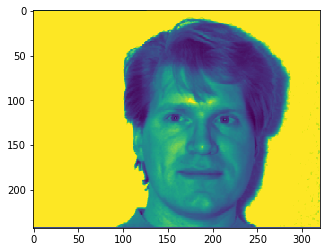

In [72]:
#Check data matrix dimensions
y1 = np.array(Image.open(path + sub1_test))
print('Original shape of each image: {}'.format(y1.shape))
plt.imshow(y1) #Show the full image

Downsized shape of each image: (61, 80)


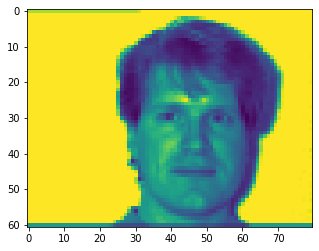

In [73]:
#Downscale images
y1 = downscale_local_mean(y1, (4,4))
print('Downsized shape of each image: {}'.format(y1.shape))
plt.imshow(y1)

In [98]:
y2 = np.array(Image.open(path + sub2_test))
y2 = downscale_local_mean(y2, (4,4))


**Here is what our 2 subjects look like:** (Note that Subject 1 corresponds to "Subject14" in the yalefaces images)


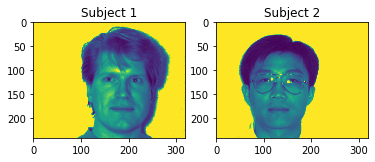

In [74]:
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title('Subject {}'.format(i+1))
    if i == 0:
        plt.imshow(np.array(Image.open(path + sub1_test)))
    else:
        plt.imshow(np.array(Image.open(path + sub2_test)))


Now that we've seen what downscaling does and what our 2 people look like, let's downscale the rest of the images in yalefaces. Each downscaled image will have new dimensions of 61x80 pixels.

However, we want to represent the data in a 2D matrix format, so we need to vectorize each image so that each image will be a $61x80 = 4880$ vector. Once we have all the vectors representing a unique image of that particular person, we can consolidate the vectors into a 2D matrix.


**Mathematically**, given *n* vectorized images of the same subject, denoted by $x_{1},x_{2},\dots,x_{n}$, we want to create data matrix $X$ defined as:

$$X=[x_{1},x_{2},\dots,x_{n}]^T \in \mathbb{R}^{n x p}$$


In other words, we want to construct a data matrix $X$ with *n* rows and *p* columns. In this case, $p=4880$. Now we just need to find out *n*, the number of images for each subject.

In [19]:
print('Subject 1 has {} images, n = {}\nSubject 2 has {} images, n = {}'.format(len(sub1),len(sub1),len(sub2),len(sub2)))

Subject 1 has 10 images, n = 10
Subject 2 has 9 images, n = 9



With that done, let's go ahead and downscale and reshape all the images for each subject.

In the code below, $X_1$ refers to Subject 1, and $X_2$ refers to Subject 2 (or, in the data, Subject 14). 


In [91]:
#reshape so p = 61x80 = 4880
#n = 10 for subject 1
X1 = np.zeros((10, 4880))
for i in range(10):
    img = np.array(Image.open(path + sub1[i]))
    downsample = downscale_local_mean(img, (4,4))
    downsample_reshape = downsample.reshape(4880)
    X1[i,:] = downsample_reshape

In [92]:
X2 = np.zeros((9, 4880))
for i in range(9):
    img = np.array(Image.open(path + sub2[i]))
    downsample = downscale_local_mean(img, (4,4))
    downsample_reshape = downsample.reshape(4880)
    X2[i,:] = downsample_reshape

## Eigendecomposition and Principal Components

Now the fun begins! Let's find the top 6 Principal Components for each subject. This is done by finding the top 6 Eigenvalues of the subject's Covariance Matrix $C$ and their corresponding Eigenvectors.

### Aside, brief explanation

If you're a bit rusty, here's a quick overview of what's happening.

If you're given a data matrix $X$ - in this instance, a matrix of all images for a subject - a representation of the "spread" of that data is the Covariance matrix $C$, defined by $C = X^TX \in \mathbb{R}^{pxp}$. The Covariance matrix quantifies the relationship between all pairs of *p* variables and how they "covary" or "move" in relation to each other. Since $C$ has $pxp$ dimensions, that means each row and each column represent individual "variables" from $X$. So for an element in $C$, that element's *Row* and *Column* represent 2 different variables from $X$. The diagonal entries of $C$ represent **one** variable's **variance**.

Every element in $C$ corresponds to a pair of the variables in the original data matrix $X$. If the value is positive, that means that the variable represented by the element's corresponding *row* has a positive proportional relationship to the variable represented by that element's corresponding *column*; if the value is negative, then the two corresponding variables have an *inverse* relationship.


Now, square matrices (i.e. matrices that have equal number of rows and columns, such as $C$) can be described using Eigendecomposition, which means finding the Eigenvectors and Eigenvalues of that matrix.

The Eigenvectors "summarize" the spread captured by $C$. They give you the orthogonal vectors (or, if you were to draw this, "arrows" that are all perpendicular to each other) corresponding to the **direction** of the spread of the data. The Eigenvalues tell you the magnitude of the Eigenvectors (i.e. how much the data spreads in that direction). The largest Eigenvalue and its corresponding Eigenvector will tell you in which direction your data is spread out **THE MOST.** 


This is the core of Principal Components: finding the top Eigenvalues and Eigenvectors of a covariance matrix ($C$) of the data ($X$). By keeping only the top Eigenvalues and Eigenvectors, we can represent our data (or images) in a "compressed" or a "simplified" format.

The eigenvectors are the "Principal Components" of the data.

If we want to see how our original data is represented by these Principal Components, we simply take the eigenvectors and use the dot product with the original data matrix $X$ to see how that Principal Component/eigenvector "projects" unto our data.

In [93]:
#Finding eigenvalues and eigenvectors
EVal, Evec = np.linalg.eigh(np.dot(X1, X1.T))

Let's stick to the Top 6 Eigenvectors, or *Eigenfaces*.

In [94]:
# Top 6 Eigenfaces
EF1 = Evec[:,-6:] #Gets Top 6 Eigenvectors corresponding to Top 6 Eigenvalues
EF1 = np.flip(EF1, axis=1) #Eigenvectors are ordered ascending; order descending
EF1 = np.dot(EF1.T, X1) #Project Eigenfaces to data X
EF1.shape #Check shape to see if correct

(6, 4880)


We see the projections of each of our 6 Principal Compoents (or top 6 Eigenfaces) unto the data matrix $X$ of each of our Subjects.


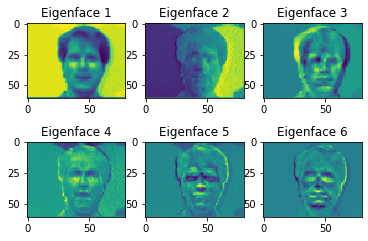

In [95]:
#Plot Eigenfaces for subject-01
import matplotlib.pyplot as plt
for i in range(EF1.shape[0]):
    img = EF1[i,:].reshape((61,80))
    plt.subplot(2,3,i+1)
    plt.title('Eigenface {}'.format(i+1))
    plt.imshow(img)

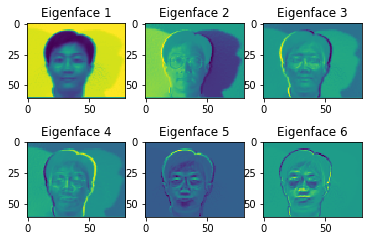

In [96]:
##Repeat for subject-14
EVal, Evec = np.linalg.eigh(np.dot(X2, X2.T))
EF2 = Evec[:,-6:] #Gets Top 6 Eigenvectors corresponding to Top 6 Eigenvalues
EF2 = np.flip(EF2, axis=1) #Eigenvectors are ordered ascending; order descending
EF2 = np.dot(EF2.T, X2) #Project Eigenfaces to data X
for i in range(EF2.shape[0]):
    img = EF2[i,:].reshape((61,80))
    plt.subplot(2,3,i+1)
    plt.title('Eigenface {}'.format(i+1))
    plt.imshow(img)


In both examples, we can see that the first *Eigenface* (a.k.a. the 1st Principal Component, a.k.a. the Eigenvector with the largest Eigenvalue) captures the original image the most, which is what we'd expect from the first Principal Component.

Some of the Eigenfaces become blurred and the faces become less and less recognizable, leaving only traces of a face. This is explained by 2 things:

1. Each proceeding Eigenface has a decreasing Eigenvalue, which means that each Eigenface captures the data variance less and less.

2. Remember that $X$ is a matrix of ALL images of a given subject. If you haven't noticed, different images show the same subject under different lighting and different angles. We are projecting each Eigenface/Eigenvector onto the ENTIRE matrix $X$, i.e. the entire collection of images. This explains the weird shading or off-color shadows in some of the Eigenface projections above.


In [35]:
k = 6
U, S, V = np.linalg.svd(X1)
Uk = U[:, :k]
Sk = np.diag(S[:k])
Vk = V[:k, :]
X1_svd = np.dot(Uk, Sk)

ef1 = np.dot(X1_svd.T, X1)

# Facial Recognition Implementation


Now that we have our top Eigenfaces/Principal Components, and now that we know we can project these Eigenfaces to our images, let's use the **test images** and see if we can use these Eigenfaces to classify the correct person.


How is this done? One method is, quite simply, **dot products**! If you remember in Linear Algebra, dot products measures how much one vector $a$ goes in the direction of another vector $b$. The formula for dot products of 2 vectors is:

$$a\cdot b = ||a||\;||b||\;cos\theta$$


The crucial term in the above formula is $cos\theta$. Geometrically, it's the cosine of the angle between vectors $a$ and $b$ if you were to draw $a$ and $b$ in a coordinate system.


Intuitively, $cos\theta$ is, quite simply, a measure of directional **similarity** between two vectors. If the 2 vectors were pointing in the EXACT same direction, $cos\theta = 1$, and the 2 vectors are directionally equivalent. If the 2 vectors were perpendicular to each other, $cos\theta = 0$, and the 2 vectors have no directional similarity.


We can use this $cos\theta$ to quantify similarity between 2 vectors! We can rearrange the equation above to find this similarity score:

$$cos\theta = \frac{a \cdot b}{||a|| \; ||b||}$$


Which 2 vectors are we gonna use? Why, the Eigenvectors and the Images, of course! More specifically, we will use the **first** Eigenface, and the **test image** for each subject. We can take the first Eigenface of each subject and calculate the similarity between the Eigenface and each subject's test image (vectorized, of course).


## Implementation steps

1. Get the 1st Eigenface/Principal Component vector of Subject 1 (EF1)
2. Get the (vectorized) test images of each Subject
3. For each test image, take the dot product of the Eigenface EF1 and that test image.
4. Divide the resulting dot product by the product of the magnitudes of EF1 and the test image.
5. Record the resulting "similarity" score between EF1 and each test image.
6. Repeat for Subject 14 (EF2)
7. For EF1, determine which similarity score is higher (Subject 1 vs. Subject 14); the Subject with higher corresponding similarity score will be the classification of EF1.


In [99]:
y1 = y1.reshape(y1.shape[0]*y1.shape[1])
y2 = y2.reshape(y2.shape[0]*y2.shape[1])

In [100]:
#Compute normalized similarity scores (L2 norm used to normalize)
score1 = np.dot(EF1[0,:], y1)/(np.linalg.norm(EF1[0,:]) * np.linalg.norm(y1))
score2 = np.dot(EF2[0,:], y1)/(np.linalg.norm(EF2[0,:]) * np.linalg.norm(y1))
score3 = np.dot(EF1[0,:], y2)/(np.linalg.norm(EF1[0,:]) * np.linalg.norm(y2))
score4 = np.dot(EF2[0,:], y2)/(np.linalg.norm(EF2[0,:]) * np.linalg.norm(y2))

In [101]:
print('''
Score EigenFace 1 vs. Subject 1: {}\n
Score EigenFace 2 vs. Subject 1: {}\n
Score EigenFace 1 vs. Subject 14: {}\n
Score EigenFace 2 vs. Subject 14: {}
'''.format(score1, score2, score3, score4))


Score EigenFace 1 vs. Subject 1: 0.9827372696838159

Score EigenFace 2 vs. Subject 1: 0.8753163024884211

Score EigenFace 1 vs. Subject 14: 0.8939572065339467

Score EigenFace 2 vs. Subject 14: 0.9907805144183152



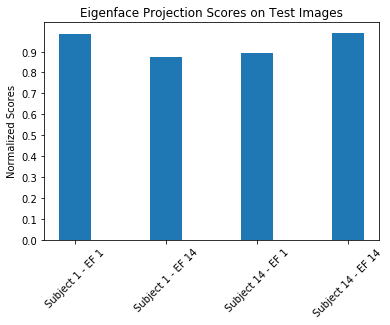

In [102]:
ind = np.arange(4)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, [score1, score2, score3, score4], width)

plt.ylabel('Normalized Scores')
plt.title('Eigenface Projection Scores on Test Images')
plt.xticks(ind, ('Subject 1 - EF 1', 'Subject 1 - EF 14', 'Subject 14 - EF 1', 'Subject 14 - EF 14'), rotation=45)
plt.yticks(np.arange(0, 1, 0.1))

plt.show()

## Conclusions

Eigenface 1's highest similarity score is with Subject 1 test image, which is correct, as Eigenface 1 corresponds to Subject 1 from the above. Likewise, Eigenface 2's highest similarity score is with Subject 14 test image.

So using these similarity scores, we can conclude that Eigenface 1 can be used to classify the Subject 1 test image, and Eigenface 2 can be used to classify the Subject 14 test image as Subject 14.


If we were to expand using the first Eigenface to classify images, we could compile more labelled images, find their respective Eigenfaces or Principal Components, compute the similarity score of those Eigenfaces against new images, and classify the new images as belonging to the image label (or group of images from where the Eigenface was derived) with the highest similarity score.

Perhaps the biggest challenges of a non-deterministic facial recognition method such as this are getting enough images to train/build the Principal Components, and tuning a similarity "threshold." The similarity scores between EF1-Subject 1, and EF1-Subject 14 are pretty different, but what if we were to repeat this exercise using 2 subjects who look very similar to each other? I'd imagine the similarity scores would be VERY close.


On the flip side, you could have an image of a cupcake and do the exact same thing as above, and the similarity scores may be VERY low, but there will be an image that has the "highest similarity" for this cupcake image and will thus be incorrectly classified. 

This was to simply show a method potentially used for facial recognition.